https://dacon.io/competitions/official/235670/codeshare/1822?page=1&dtype=recent

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer,PorterStemmer
from collections import defaultdict, Counter
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy
from spacy import displacy
import gensim
import pyLDAvis.gensim_models
from textstat import flesch_reading_ease

from sklearn.feature_extraction.text import CountVectorizer

import re
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("data/train.csv", encoding="utf-8")
train['text_lower'] = train['text'].str.lower()
test = pd.read_csv("data/test_x.csv", encoding="utf-8")

### 작가별 건수

<AxesSubplot:>

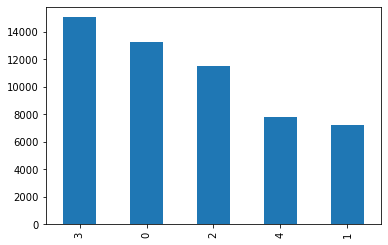

In [2]:
train['author'].value_counts().plot(kind='bar')

### 문자 길이 분포

<AxesSubplot:>

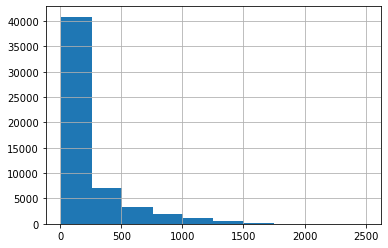

In [3]:
train['text'].str.len().hist()

### word level length(단어 기준 길이 분포)

In [4]:
def plot_word_number_histogram(text):
    text.str.split().map(lambda x:len(x)).hist()

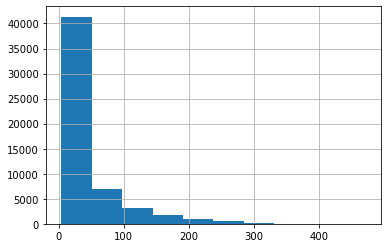

In [5]:
plot_word_number_histogram(train['text'])

### average word length

In [6]:
def plot_word_length_histogram(text):
    text.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x)).hist()

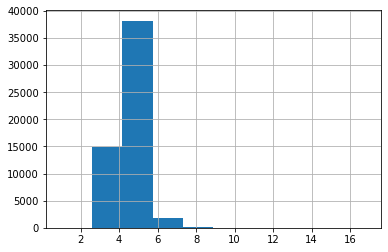

In [7]:
plot_word_length_histogram(train['text'])

### stopwords 분포

In [8]:
stop = set(stopwords.words('english'))
dic = defaultdict(int)

new = train['text'].str.split()
new = new.values.tolist()
corpus= [word for i in new for word in i]

In [9]:
def plot_top_stopwords_barchart(text):
    new = text.str.split()
    new = new.values.tolist()
    corpus= [word for i in new for word in i]
    
    for word in corpus:
        if word in stop:
            dic[word] += 1
    
    top = sorted(dic.items(), key = lambda x : x[1], reverse=True)[:10]
    x, y = zip(*top)
    return x, y

<BarContainer object of 10 artists>

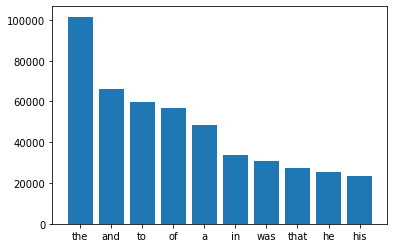

In [10]:
x, y = plot_top_stopwords_barchart(train['text'])
plt.bar(x, y)

### 작가별 stopwords 분포

In [11]:
plot_top_stopwords_barchart(train[train['author'] == 0]['text'])

(('the', 'and', 'to', 'of', 'a', 'in', 'was', 'that', 'he', 'his'),
 (122875, 81408, 72800, 68360, 59199, 41450, 37063, 33274, 29931, 28613))

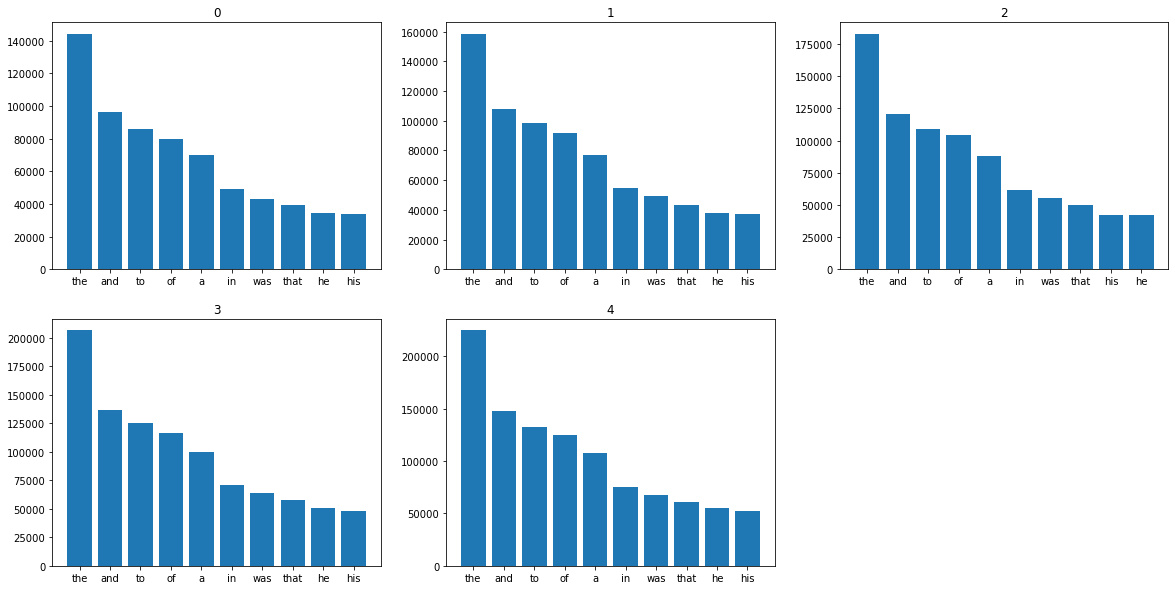

In [12]:
fig = plt.figure(figsize=(20, 10))
rows = 2
cols = 3
i = 0

for i in range(5):
    x, y = plot_top_stopwords_barchart(train[train['author'] == i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    ax.bar(x, y)

### corpus

In [13]:
def plot_top_non_stopwords_barchart(text):
    new = text.str.split()
    new = new.values.tolist()
    corpus= [word for i in new for word in i]
    
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    
    for word, count in most[:40]:
        if word not in stop:
            x.append(word)
            y.append(count)
        
    return x, y

In [14]:
x, y = plot_top_non_stopwords_barchart(train['text'])

<AxesSubplot:>

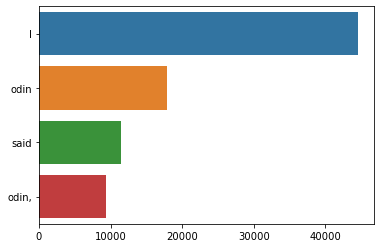

In [15]:
sns.barplot(x=y,y=x)

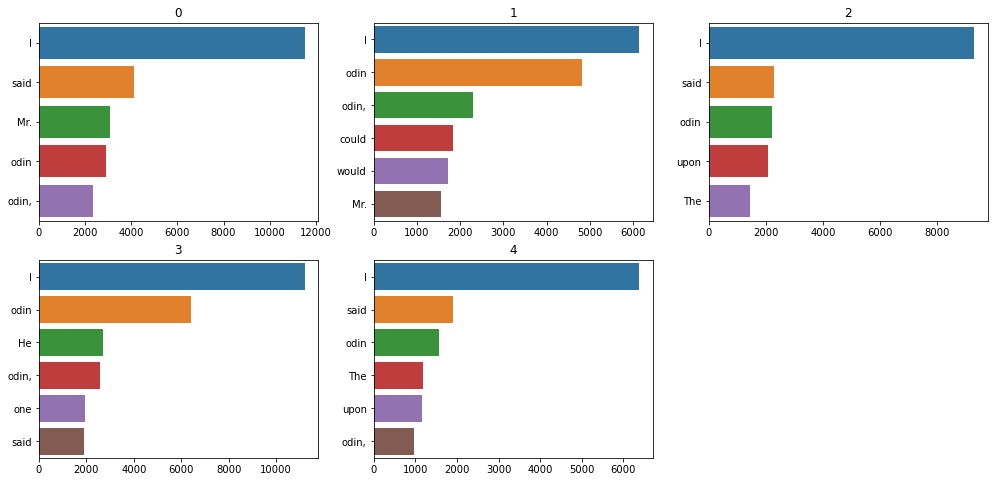

In [16]:
fig = plt.figure(figsize=(17, 8))
rows = 2
cols = 3

for i in range(5):
    x, y = plot_top_non_stopwords_barchart(train[train['author'] == i]['text'])
    ax = fig.add_subplot(rows,cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y, y=x)

In [17]:
def plot_top_non_stopwords_barchart2(text):
    new = text.str.split()
    new = new.values.tolist()
    corpus= [word for i in new for word in i]
    
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    
    for word, count in most[:70]:
        if word not in stop:
            x.append(word)
            y.append(count)
        
    return x, y

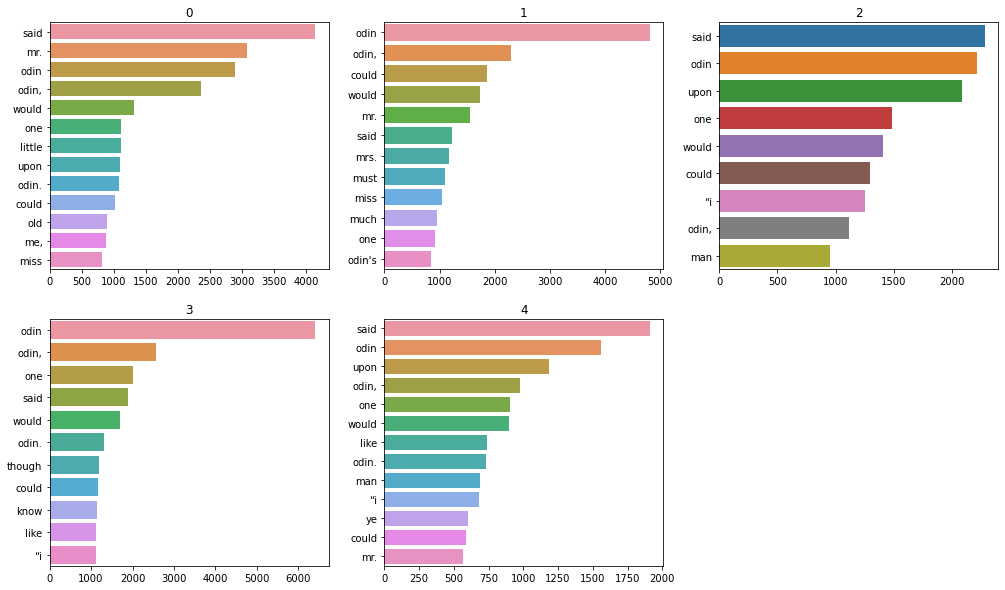

In [18]:
fig = plt.figure(figsize=(17, 10))
rows = 2
cols = 3

for i in range(5):
    x, y = plot_top_non_stopwords_barchart2(train[train['author'] == i]['text_lower'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y, y=x)

### Ngram exploration

In [19]:
list(ngrams(['I', 'went', 'to', 'the', 'river', 'bank'], 2))

[('I', 'went'),
 ('went', 'to'),
 ('to', 'the'),
 ('the', 'river'),
 ('river', 'bank')]

In [20]:
def plot_top_ngrams_barchart(text, n=2):
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    
    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                     for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x : x[1], reverse=True)
        return words_freq[:10]
    
    top_n_bigrams = _get_top_ngram(text, n )[:10]
    x, y = map(list, zip(*top_n_bigrams))
    return x, y

<AxesSubplot:>

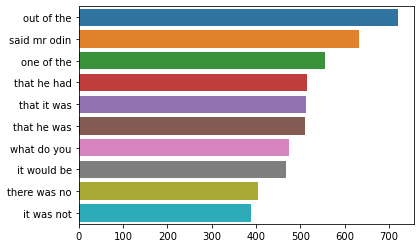

In [21]:
x, y = plot_top_ngrams_barchart(train['text'], n=3)
sns.barplot(y, x)

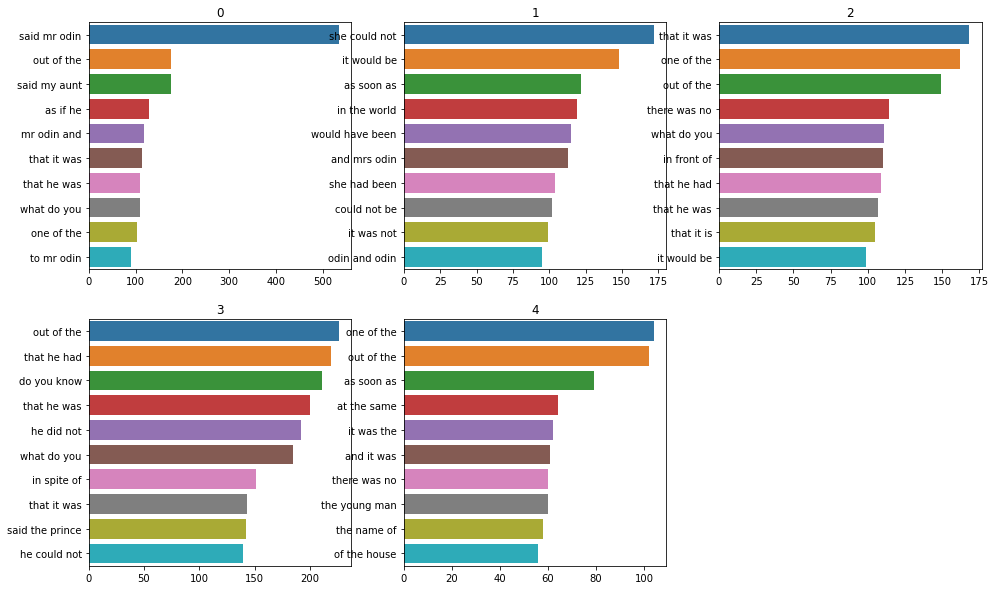

In [22]:
fig = plt.figure(figsize=(16, 10))
rows = 2
cols = 3

for i in range(5):
    x, y = plot_top_ngrams_barchart(train[train['author'] == i]['text'], n=3)
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y, y=x)

### Topic Modeling exploration with pyLDAvis

- Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.
- Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/sol/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
NUM_TOPICS = 5

def _preprocess_text(text):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for news in text:
        words = [w for w in word_tokenize(news) if (w not in stop)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)

    return corpus

def get_lda_objects(text):
    
    corpus = _preprocess_text(text)
    
    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model = gensim.models.LdaMulticore(bow_corpus,
                                          num_topics = NUM_TOPICS,
                                          id2word = dic,
                                          passes = 10,
                                          workers = 2)
    
    return lda_model, bow_corpus, dic

In [25]:
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

In [26]:
lda_model, bow_corpus, dic = get_lda_objects(train['text_lower'])

In [27]:
lda_model.show_topics()

[(0,
  '0.042*"odin" + 0.028*"said" + 0.017*"know" + 0.013*"come" + 0.012*"n\'t" + 0.011*"cried" + 0.011*"..." + 0.011*"one" + 0.011*"say" + 0.009*"like"'),
 (1,
  '0.017*"odin" + 0.011*"could" + 0.010*"would" + 0.010*"one" + 0.006*"time" + 0.005*"even" + 0.005*"might" + 0.005*"man" + 0.005*"day" + 0.005*"every"'),
 (2,
  '0.028*"odin" + 0.010*"hand" + 0.008*"face" + 0.008*"eye" + 0.008*"upon" + 0.007*"looked" + 0.007*"one" + 0.007*"room" + 0.007*"door" + 0.006*"came"'),
 (3,
  '0.015*"upon" + 0.009*"man" + 0.007*"would" + 0.006*"lord" + 0.006*"sir" + 0.006*"men" + 0.006*"one" + 0.005*"like" + 0.005*"great" + 0.004*"cried"'),
 (4,
  '0.082*"odin" + 0.034*"said" + 0.023*"mr." + 0.011*"would" + 0.009*"sir" + 0.009*"miss" + 0.009*"think" + 0.009*"well" + 0.008*"asked" + 0.008*"mrs."')]

In [28]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.043394 -0.118450       1        1  26.988559
2      0.147175 -0.135004       2        1  23.568840
4     -0.168794 -0.006735       3        1  22.350047
0     -0.138310  0.115066       4        1  15.698548
3      0.203324  0.145123       5        1  11.394005, topic_info=      Term          Freq         Total Category  logprob  loglift
40    said  12916.000000  12916.000000  Default  30.0000  30.0000
13    odin  38347.000000  38347.000000  Default  29.0000  29.0000
34     mr.   5785.000000   5785.000000  Default  28.0000  28.0000
455   know   4761.000000   4761.000000  Default  27.0000  27.0000
133   upon   5293.000000   5293.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
800   good    368.358710   3008.188947   Topic5  -5.7914   0.0720
151    may    327.209528   2831.724116   Topic5  -5.9099   0.0140
267   back    316.484660   2380.218496   Topic5  -5.9432   0.1544
383  never    309.856258   3050.256309   Topic5  -5.9643  -0.1148
8     hand    307.254839   3704.999689   Topic5  -5.9728  -0.3177

[410 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4748      4  0.989542    'em
4321      4  0.993042    'he
512       4  0.987363    'is
741       4  0.999600    'll
4781      3  0.995452    'no
...     ...       ...    ...
557       1  0.399057  young
557       2  0.171772  young
557       3  0.352448  young
557       4  0.054988  young
557       5  0.022519  young

[820 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 1, 4])

### wordcloud

In [29]:
def plot_wordcloud(text):
    
    corpus = _preprocess_text(text)
    
    wordcloud = WordCloud(background_color="white",
                         stopwords=set(STOPWORDS),
                         max_words=100,
                         max_font_size=30,
                         scale=3,
                         random_state=1)
    wordcloud = wordcloud.generate(str(corpus))
    return wordcloud

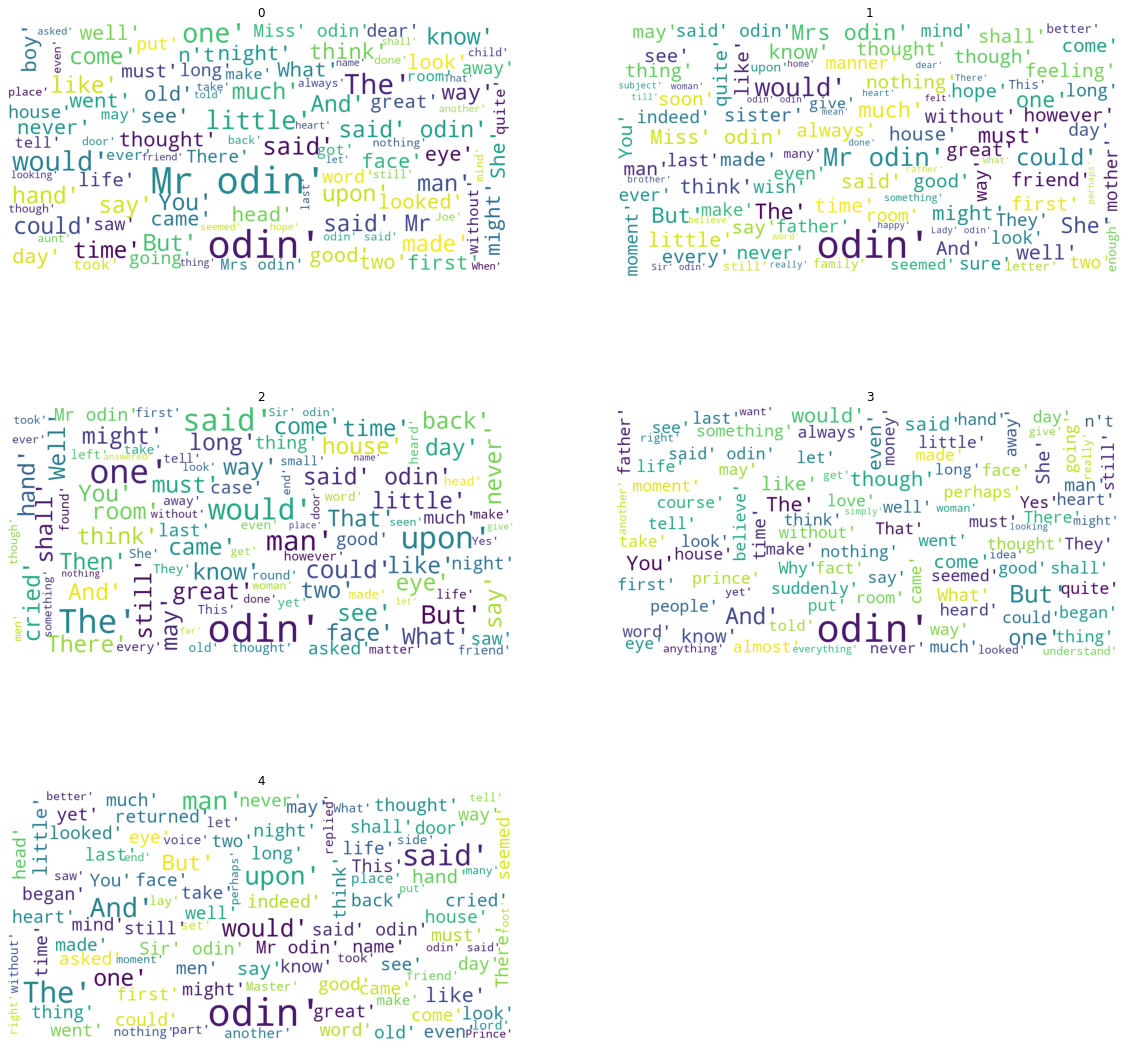

In [30]:
fig = plt.figure(figsize=(20, 20))
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud(train[train['author'] == i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

### 명사만

In [31]:
nltk.download('averaged_perceptron_tagger')

def _preprocess_text_noun(text, tags):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for news in text:
        words = [w for w in word_tokenize(news) if (w not in stop)]
        words = [lem.lemmatize(w) for w in words if len(w) > 2]
        
        tagged = nltk.pos_tag(words)
        allnoun = [word for word, pos in tagged if pos in tags]
        
        corpus.append(allnoun)
    return corpus

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sol/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [32]:
def plot_wordcloud_noun(text, tags=['NN', 'NNP']):
    
    corpus = _preprocess_text_noun(text, tags)
    
    wordcloud = WordCloud(background_color="white",
                         stopwords=set(STOPWORDS),
                         max_words=100,
                         max_font_size=30,
                         scale=3,
                         random_state=1)
    wordcloud = wordcloud.generate(str(corpus))
    return wordcloud

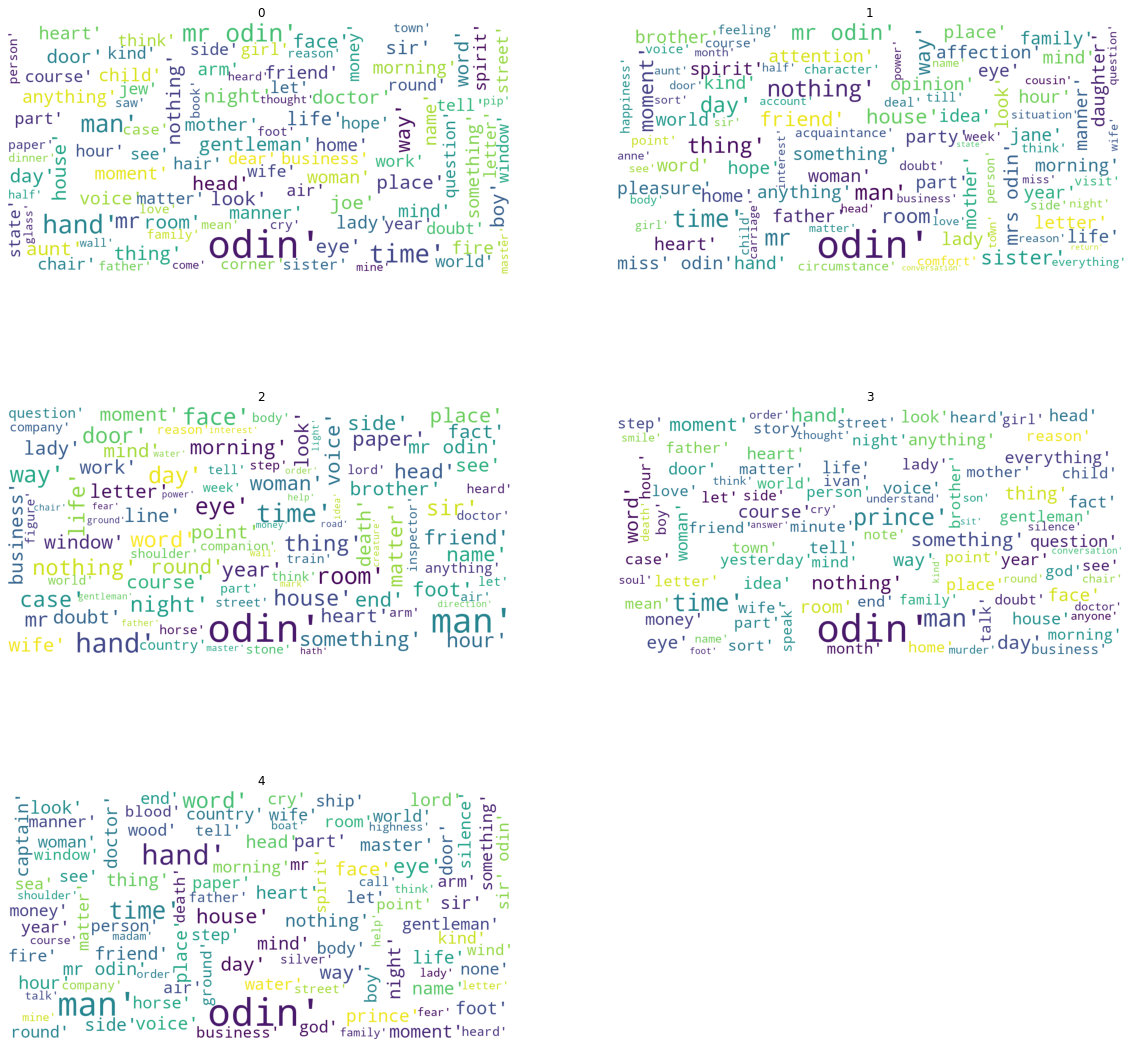

In [33]:
fig = plt.figure(figsize=(20, 20))
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(train[train['author'] == i]['text_lower'], ['NN', 'NNP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis("off")
    ax.set_title(i)
    ax.imshow(wordcloud)

### 동사만

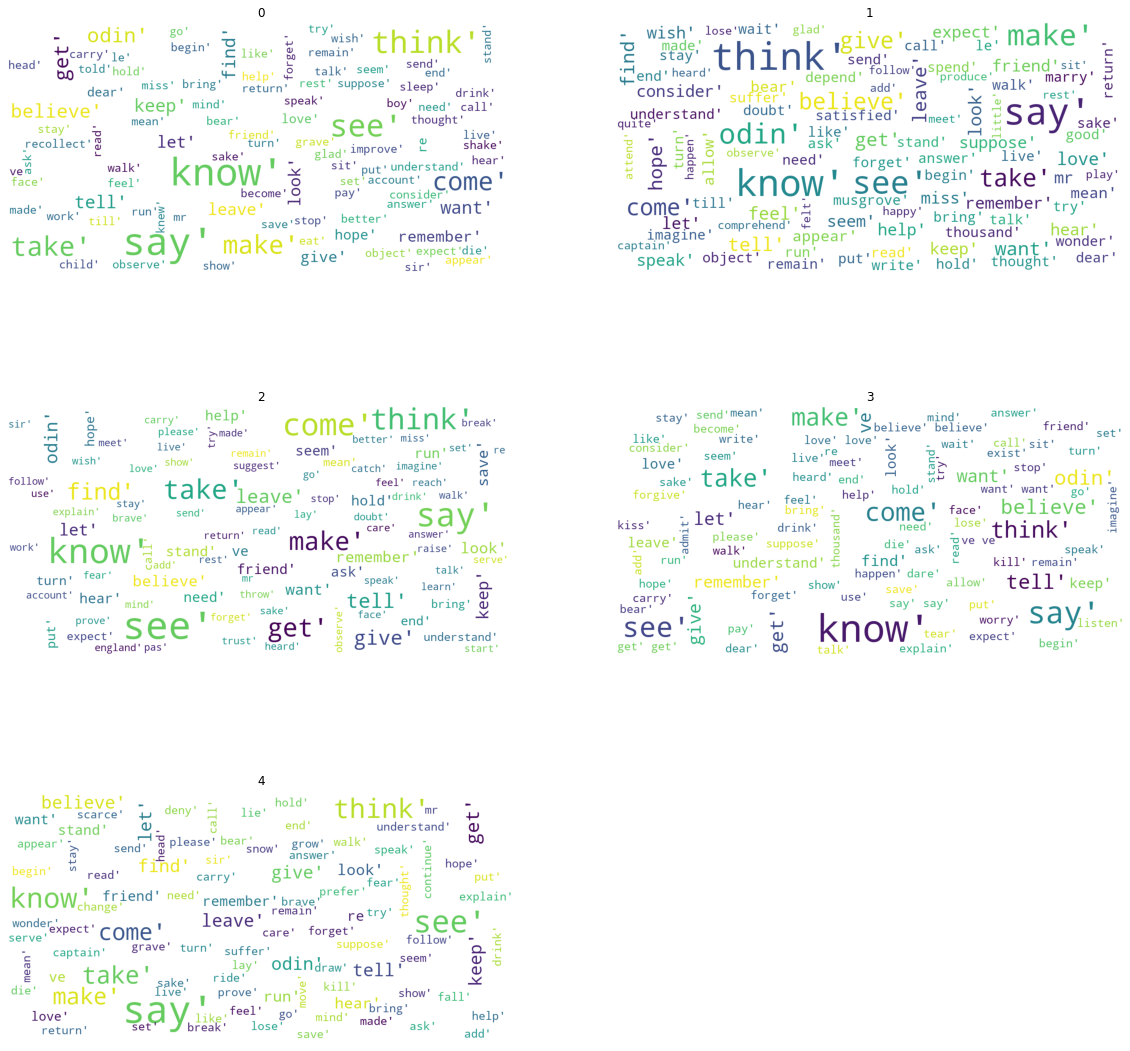

In [34]:
fig = plt.figure(figsize=(20, 20))
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(train[train['author'] == i]['text_lower'], ['VB', 'VBP'])
    ax = fig.add_subplot(rows,cols, i+1)
    ax.axis("off")
    ax.set_title(i)
    ax.imshow(wordcloud)

## Sentiment analysis
### Textblob
Textblob is a python library built on top of nltk. It has been around for some time and is very easy and convenient to use.

The sentiment function of TextBlob returns two properties:

- polarity: is a floating-point number that lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.

- subjectivity: refers to how someone’s judgment is shaped by personal opinions and feelings. Subjectivity is represented as a floating-point value which lies in the range of [0,1].

In [35]:
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

In [36]:
def _polarity(text):
    return TextBlob(text).sentiment.polarity

In [37]:
def plot_polarity_hist(text):
    polarity_score = text.apply(lambda x : _polarity(x))
    return polarity_score

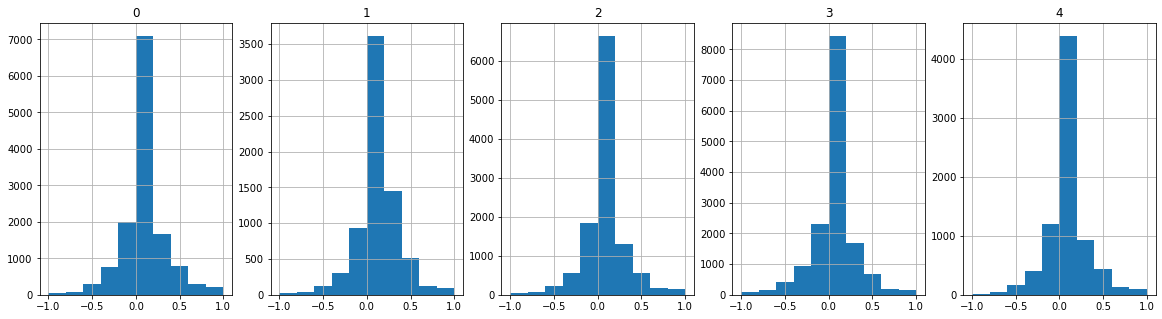

In [38]:
fig = plt.figure(figsize=(20, 5))
rows = 1
cols = 5

for i in range(5):
    polarity_score = plot_polarity_hist(train[train['author'] == i]['text_lower'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    polarity_score.hist()

In [39]:
def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

In [40]:
def sentiment_textblob(text):
    x = TextBlob(text).sentiment.polarity
    
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'

In [41]:
def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x : sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x : sentiment_vader(x, sid=sid))
    else:
        raise ValeError('Textblob or Vader')
    
    return sentiment 

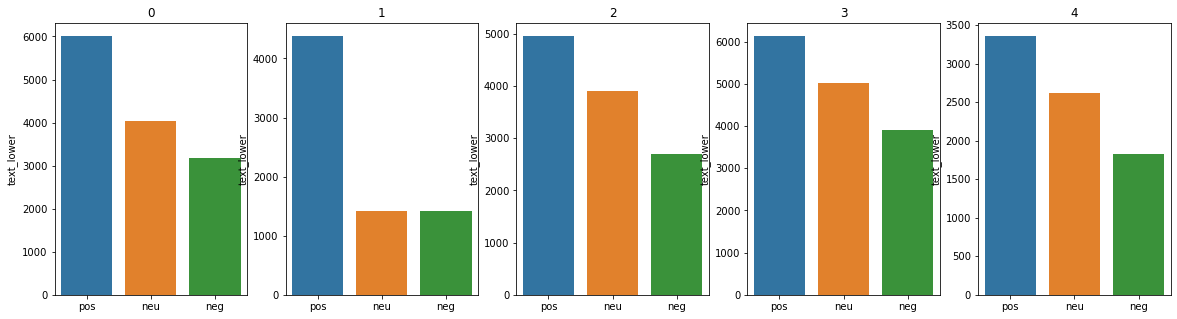

In [42]:
fig = plt.figure(figsize=(20, 5))
rows = 1
cols = 5

for i in range(5):
    sentiment = plot_sentiment_barchart(train[train['author'] == i]['text_lower'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(sentiment.value_counts().index, sentiment.value_counts())

## Named Entity Recognition(개체명인식 NER)
### spaCy
spaCy provides many other functionalities like pos tagging, word to vector transformation, etc.

In [53]:
nlp = spacy.load("en_core_web_sm")

In [44]:
doc=nlp('India and Iran have agreed to boost the economic viability \
of the strategic Chabahar port through various measures, \
including larger subsidies to merchant shipping firms using the facility, \
people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'), ('Iran', 'GPE'), ('Thursday', 'DATE')]

In [45]:
doc.ents

(India, Iran, Thursday)

In [46]:
def _get_ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

In [58]:
import swifter

In [59]:
def plot_named_entity_barchart(text):
    ent = text.swifter.apply(lambda x : _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()
    
    x, y = map(list, zip(*count))
    return x, y

  0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13235 [00:00<?, ?it/s]

 20%|██        | 1/5 [04:33<18:15, 273.79s/it]

Pandas Apply:   0%|          | 0/7222 [00:00<?, ?it/s]

 40%|████      | 2/5 [07:59<11:40, 233.54s/it]

Pandas Apply:   0%|          | 0/11554 [00:00<?, ?it/s]

 60%|██████    | 3/5 [12:03<07:57, 238.65s/it]

Pandas Apply:   0%|          | 0/15063 [00:00<?, ?it/s]

 80%|████████  | 4/5 [17:34<04:34, 274.92s/it]

Pandas Apply:   0%|          | 0/7805 [00:00<?, ?it/s]

100%|██████████| 5/5 [20:26<00:00, 245.34s/it]


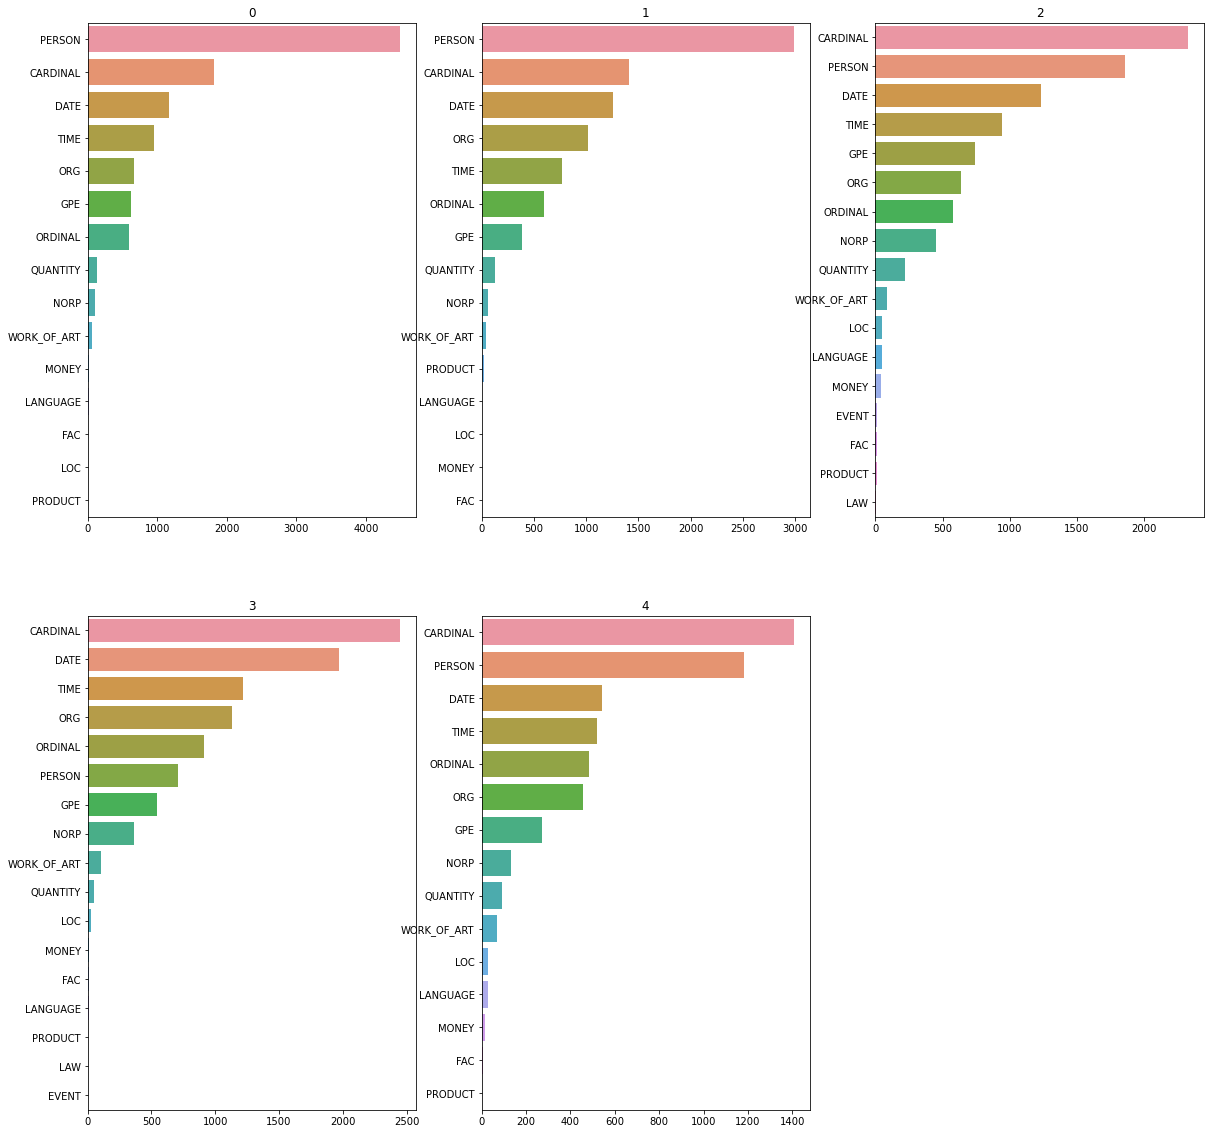

In [60]:
fig = plt.figure(figsize=(20, 20))
rows = 2
cols = 3

for i in tqdm(range(5)):
    x, y = plot_named_entity_barchart(train[train['author'] == i]['text_lower'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y, y=x)

### 사람이름 분포

In [88]:
def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    entity_filtered = text.swifter.apply(lambda x : _get_ner_ent(x, entity))
    entity_filtered = [i for x in entity_filtered for i in x]
    
    counter = Counter(entity_filtered)
    x, y = map(list, zip(*counter.most_common(10)))
    return x, y

def _get_ner_ent(text, ent):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

  0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13235 [00:00<?, ?it/s]

 20%|██        | 1/5 [04:32<18:08, 272.18s/it]

Pandas Apply:   0%|          | 0/7222 [00:00<?, ?it/s]

 40%|████      | 2/5 [08:01<11:44, 234.94s/it]

Pandas Apply:   0%|          | 0/11554 [00:00<?, ?it/s]

 60%|██████    | 3/5 [12:08<08:00, 240.42s/it]

Pandas Apply:   0%|          | 0/15063 [00:00<?, ?it/s]

 80%|████████  | 4/5 [17:47<04:39, 279.57s/it]

Pandas Apply:   0%|          | 0/7805 [00:00<?, ?it/s]

100%|██████████| 5/5 [20:40<00:00, 248.13s/it]


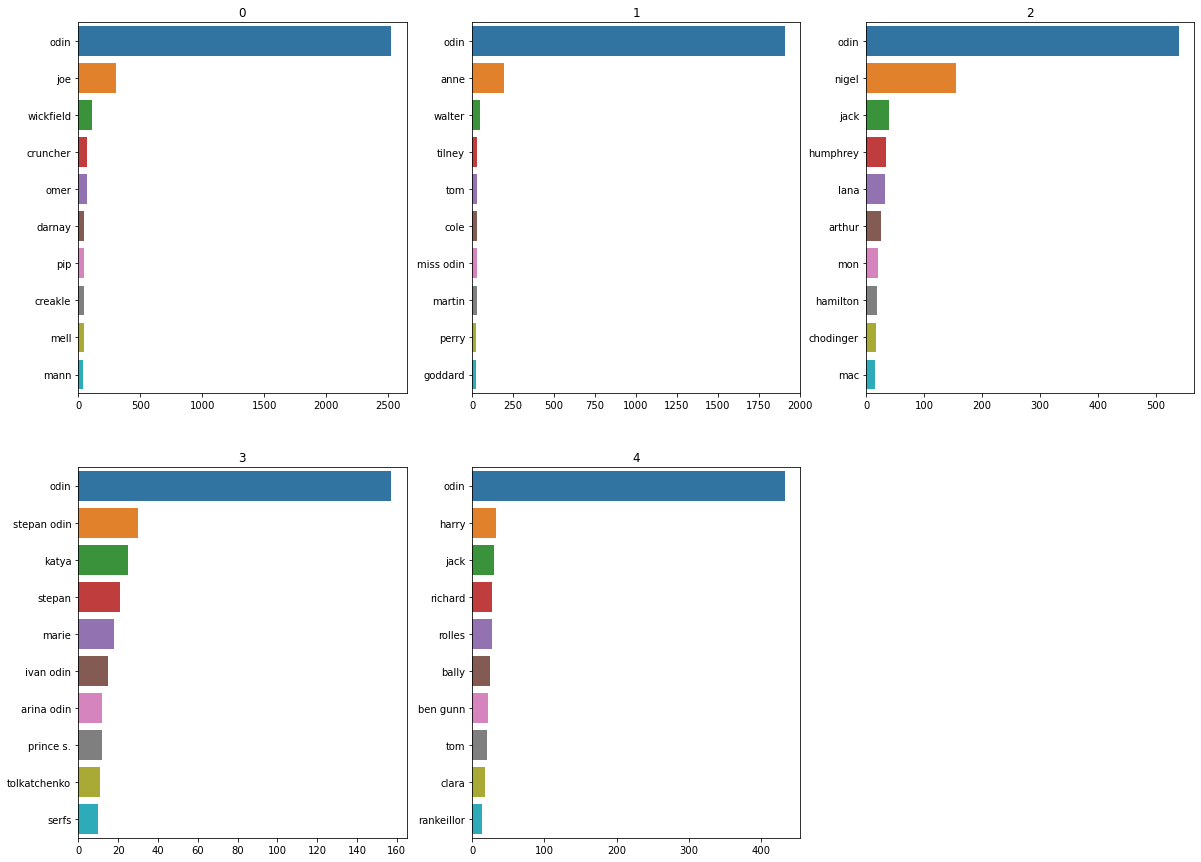

In [89]:
fig = plt.figure(figsize=(20, 15))
rows = 2
cols = 3

for i in tqdm(range(5)):
    x, y = plot_most_common_named_entity_barchart(train[train['author'] == i]['text_lower'], entity="PERSON")
    ax = fig.add_subplot(rows, cols, i+1)
    sns.barplot(y, x).set_title(i)

## Exploration through Parts of Speach Tagging in Python

In [90]:
sentence = "The greatest comeback storiex in 2019"
tokens = word_tokenize(sentence)
nltk.pos_tag(tokens)

[('The', 'DT'),
 ('greatest', 'JJS'),
 ('comeback', 'NN'),
 ('storiex', 'NN'),
 ('in', 'IN'),
 ('2019', 'CD')]

In [96]:
doc = nlp("The greatest comeback storiex in 2019")
displacy.render(doc, style='dep', jupyter =True, options={'distance':90})

In [154]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;_]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [155]:
def _filter_pos(text, part_of_speach='NN'):
    pos_type = []
    text = clean_text(text)
    pos = nltk.pos_tag(word_tokenize(text))
    for word, tag in pos:
        if tag == part_of_speach:
            pos_type.append(word)
    return pos_type

In [156]:
def plot_most_common_part_of_speach_barchart(text, part_of_speach='NN'):
    words = text.swifter.apply(lambda x : _filter_pos(x))
    words = [x for l in words for x in l]
    counter = Counter(words)
    x, y = list(map(list, zip(*counter.most_common(7))))
    return x, y

### 명사 분포

  0%|          | 0/5 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/13235 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:38,  9.51s/it]

Pandas Apply:   0%|          | 0/7222 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:16<00:24,  8.16s/it]

Pandas Apply:   0%|          | 0/11554 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:25<00:16,  8.32s/it]

Pandas Apply:   0%|          | 0/15063 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:36<00:09,  9.54s/it]

Pandas Apply:   0%|          | 0/7805 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:42<00:00,  8.53s/it]


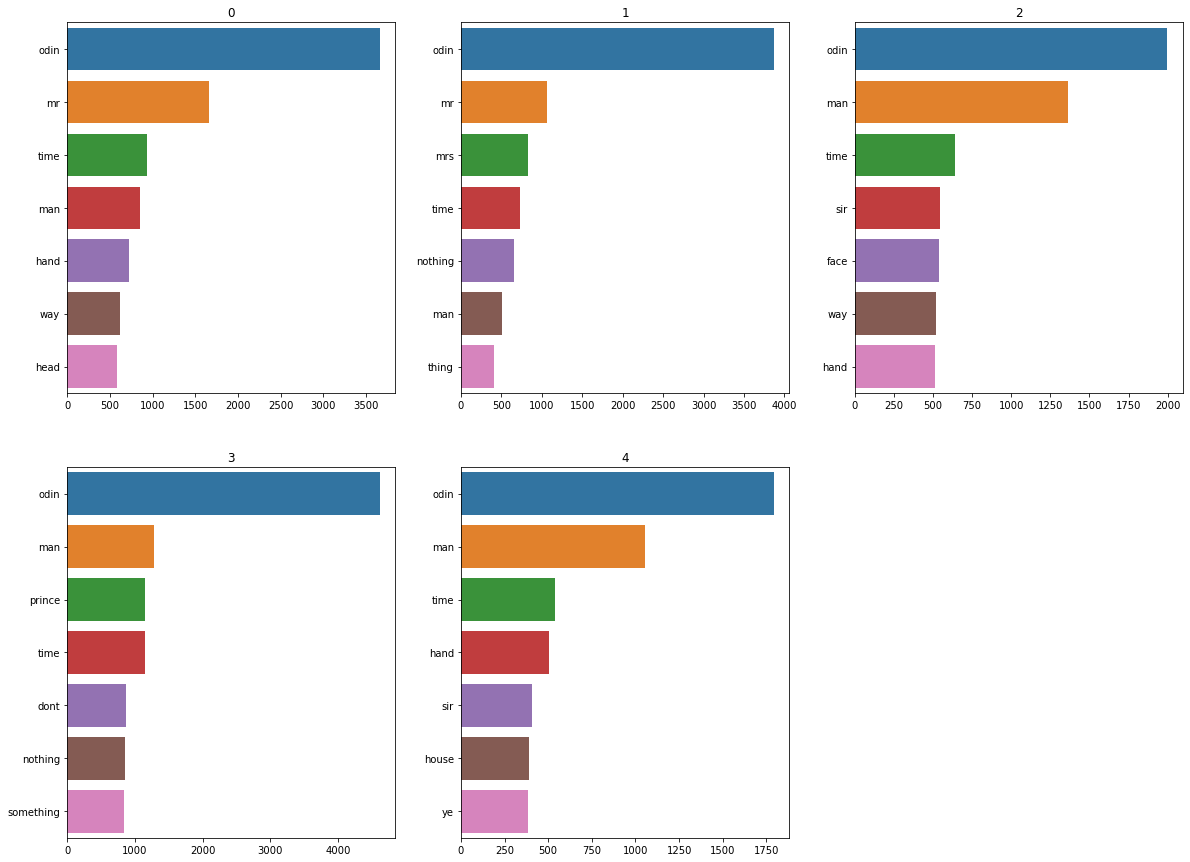

In [157]:
fig = plt.figure(figsize=(20, 15))
rows = 2
cols = 3

for i in tqdm(range(5)):
    x, y = plot_most_common_part_of_speach_barchart(train[train['author'] == i]['text_lower'], part_of_speach='NN')
    ax = fig.add_subplot(rows, cols, i+1)
    sns.barplot(x=y, y=x).set_title(i)

### 명사(NNP) 분포

Pandas Apply:   0%|          | 0/13235 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7222 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11554 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15063 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7805 [00:00<?, ?it/s]

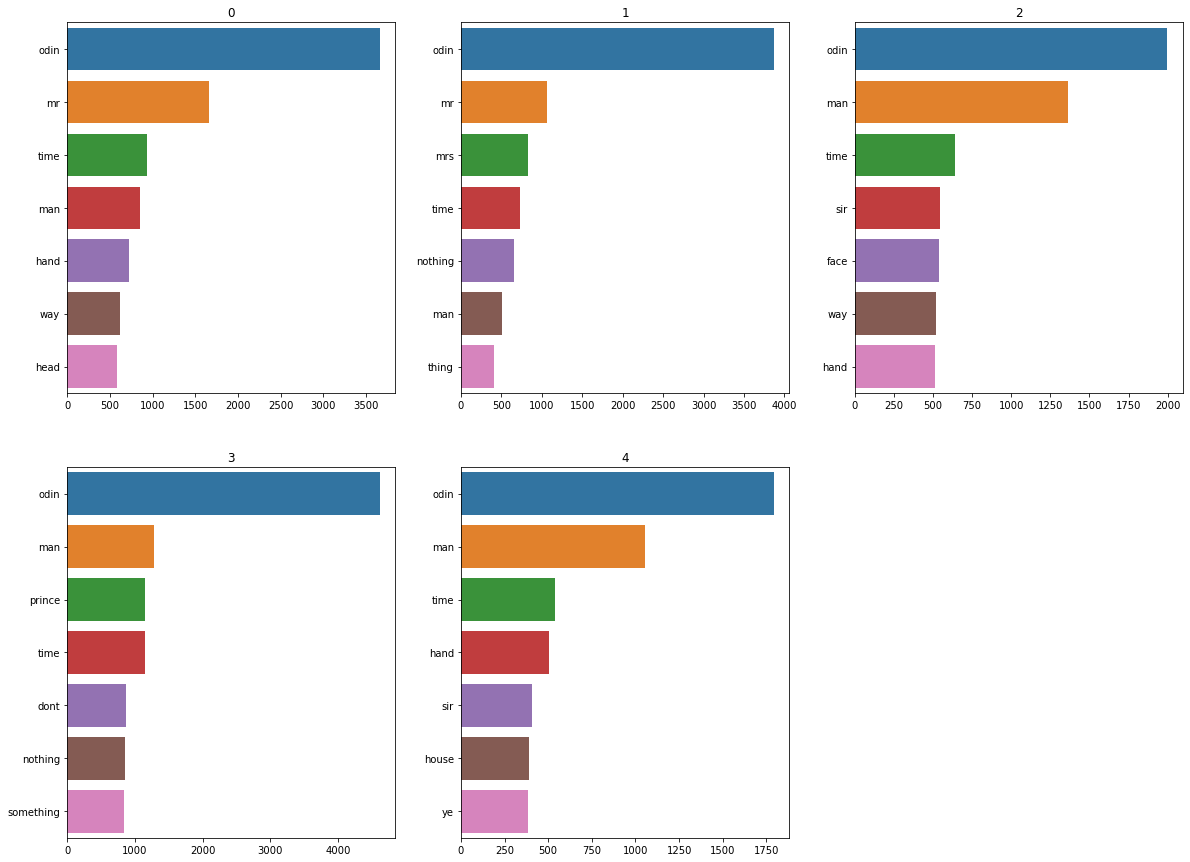

In [158]:
fig = plt.figure(figsize=(20, 15))
rows = 2
cols = 3

for i in range(5):
    x, y = plot_most_common_part_of_speach_barchart(train[train['author'] == i]['text_lower'], part_of_speach='NNP')
    ax = fig.add_subplot(rows, cols, i+1)
    sns.barplot(y, x).set_title(i)

## Exploring through text complexity
### Textstat
Textstat is a cool Python library that provides an implementation of all these text statistics calculation methods. Let’s use Textstat to implement Flesch Reading Ease index.

Pandas Apply:   0%|          | 0/13235 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7222 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/11554 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/15063 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7805 [00:00<?, ?it/s]

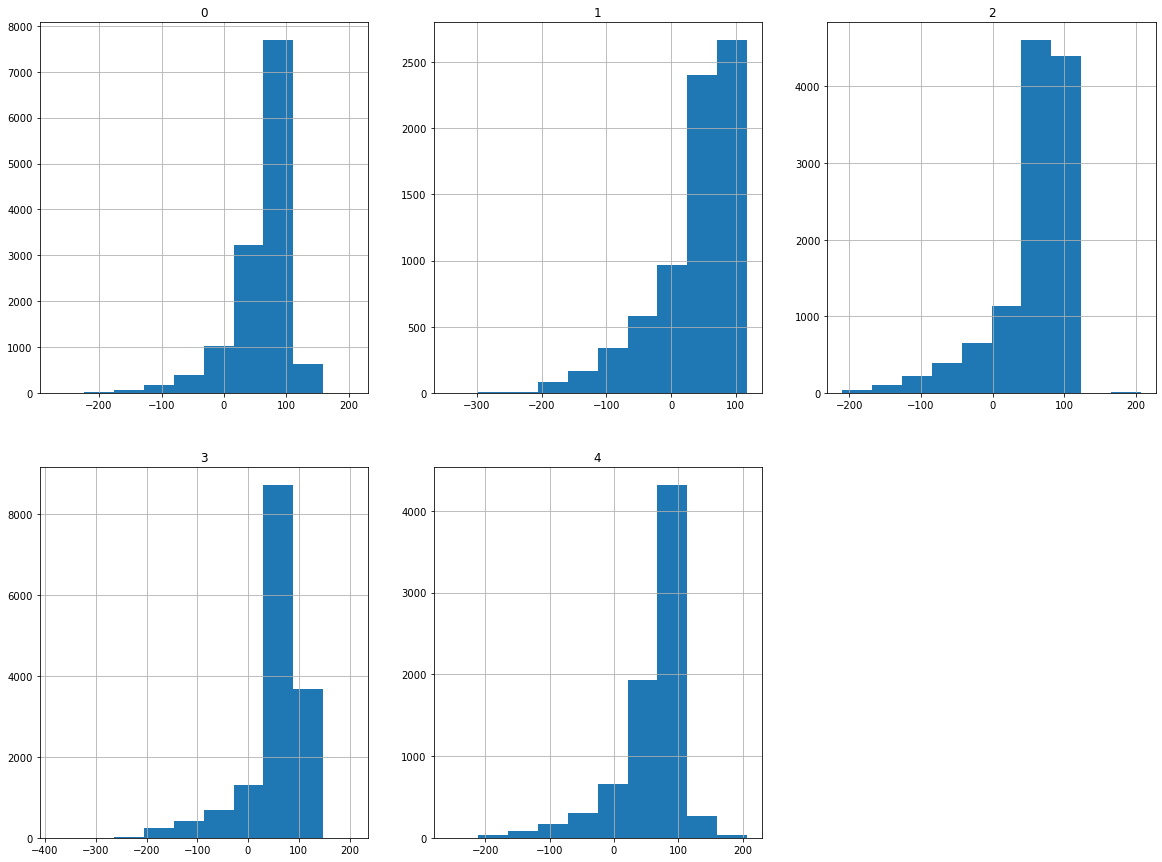

In [161]:
fig = plt.figure(figsize=(20, 15))
rows = 2
cols = 3

for i in range(5):
    text = train[train['author'] == i]['text_lower']
    ax = fig.add_subplot(rows, cols, i+1)
    text.swifter.apply(lambda x : flesch_reading_ease(x)).hist().set_title(i)

In [165]:
for i in tqdm(range(12)):
    
    print(flesch_reading_ease(train.iloc[i]['text_lower']), train.iloc[i]['author'], train.iloc[i]['text_lower'])

100%|██████████| 12/12 [00:00<00:00, 1014.36it/s]

50.17 3 he was almost choking. there was so much, so much he wanted to say, but strange exclamations were all that came from his lips. the pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.
81.29 2 “your sister asked for it, i suppose?”
39.0 1  she was engaged one day as she walked, in perusing jane’s last letter, and dwelling on some passages which proved that jane had not written in spirits, when, instead of being again surprised by mr. odin, she saw on looking up that odin was meeting her. putting away the letter immediately and forcing a smile, she said:
37.99 4 the captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. he turned and spoke to us, “doctor's watch on the lookout. dr. odin take the north side, if you please; jim, the east; gray, west. the watch below, all hands to load muskets. lively, men, and careful.”
57.27 3 “have mercy, gentlemen!” odin flung up h

#### 평균

In [ ]:
for i in range(5):
    text = train[train['']]